In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seqlogo as sl
from collections import Counter

In [2]:
import splanl.post_processing as pp
import splanl.custom_splai_scores as css

Using TensorFlow backend.


In [3]:
mane_bd = pd.read_table( '/nfs/kitzman2/smithcat/refs/gencode/gencode.v38lift37.MANESelect.bed',
                         names = [ 'chrom', 'start', 'end', 'name', 'score', 'strand' ] )

In [4]:
mane_bd

,chrom,start,end,name,score,strand
0,chr1,65565,65573,ENSG00000186092.7_1,.,+
1,chr1,69037,70005,ENSG00000186092.7_1,.,+
2,chr1,859812,860328,ENSG00000187634.13_1,.,+
3,chr1,861302,861393,ENSG00000187634.13_1,.,+
4,chr1,865535,865716,ENSG00000187634.13_1,.,+
...,...,...,...,...,...,...
176469,chrY,59230782,59230919,ENSG00000124333.16_1_PAR_Y,.,+
176470,chrY,59233167,59233257,ENSG00000124333.16_1_PAR_Y,.,+
176471,chrY,59252483,59252550,ENSG00000124333.16_1_PAR_Y,.,+
176472,chrY,59272371,59272463,ENSG00000124333.16_1_PAR_Y,.,+


In [5]:
#this removes the l exon in each entry - don't want 3' UTR
#should I do more to remove non-coding exons?
#mane_bd_filt = mane_bd.loc[ mane_bd.groupby( 'name' ).cumcount( ascending = True  ) > 0 ].copy()

In [6]:
mane_gtf = pd.read_table( '/nfs/kitzman2/smithcat/refs/gencode/gencode.v38lift37.MANESelect.gtf.gz',
                               compression = 'gzip',
                                sep = '\t',
                               comment = '#',
                               index_col = False,
                               names = [ 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute' ] )
                                #dtype = { 'CHROM': object } )

In [7]:
mane_gtf[ 'gene_type' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' ) 
                                 for att in mane_gtf.attribute 
                                 for a in att.split( '; ' )
                                 if a.split( ' ' )[ 0 ] == 'gene_type' ]

In [8]:
mane_gtf[ 'gene_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' ) 
                                 for att in mane_gtf.attribute 
                                 for a in att.split( '; ' )
                                 if a.split( ' ' )[ 0 ] == 'gene_id' ]

In [9]:
mane_gtf.loc[ mane_gtf.feature != 'gene', 'transcript_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                                                                          for att in mane_gtf.attribute
                                                                          for a in att.split( '; ' )
                                                                          if a.split( ' ' )[ 0 ] == 'transcript_id'  ]

In [10]:
gene_to_trans = { gene: trans 
                  for trans,gene in zip( mane_gtf.loc[ mane_gtf.feature != 'gene' ].transcript_id,
                                         mane_gtf.loc[ mane_gtf.feature != 'gene' ].gene_id ) }

In [11]:
mane_gtf.loc[ mane_gtf.feature == 'gene', 'transcript_id' ] = mane_gtf.loc[ mane_gtf.feature == 'gene' ].gene_id.apply( lambda x: gene_to_trans[ x ] )

In [12]:
mane_gtf.loc[ mane_gtf.feature == 'exon', 'exon_id' ] = [ a.split( ' ' )[ 1 ].replace( '"', '' )
                                                                          for att in mane_gtf.loc[ mane_gtf.feature == 'exon' ].attribute
                                                                          for a in att.split( '; ' )
                                                                          if a.split( ' ' )[ 0 ] == 'exon_id'  ]

In [13]:
ex_counts = mane_gtf[ [ 'transcript_id', 'exon_id' ] ].groupby( 'transcript_id' ).nunique()

In [14]:
mult_exons = ex_counts.loc[ ( ex_counts.exon_id > 1 ) ].index.tolist()

In [15]:
mane_gtf_mult = mane_gtf.set_index( 'transcript_id' ).loc[ mult_exons ].reset_index().copy()

In [16]:
mane_gtf_mult

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
0,ENST00000000233.10_1,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,NaN
1,ENST00000000233.10_1,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
2,ENST00000000233.10_1,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENSE00001872691.2_1
3,ENST00000000233.10_1,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469786,ENST00000684770.1_1,chr7,HAVANA,exon,143424506,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,ENSE00003918454.1_1
469787,ENST00000684770.1_1,chr7,HAVANA,CDS,143424506,143424757,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469788,ENST00000684770.1_1,chr7,HAVANA,UTR,143424758,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [17]:
mane_gtf_prot = mane_gtf_mult.loc[ mane_gtf_mult.gene_type == 'protein_coding' ].copy()

In [18]:
mane_gtf_prot

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
0,ENST00000000233.10_1,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,NaN
1,ENST00000000233.10_1,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
2,ENST00000000233.10_1,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENSE00001872691.2_1
3,ENST00000000233.10_1,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469786,ENST00000684770.1_1,chr7,HAVANA,exon,143424506,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,ENSE00003918454.1_1
469787,ENST00000684770.1_1,chr7,HAVANA,CDS,143424506,143424757,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469788,ENST00000684770.1_1,chr7,HAVANA,UTR,143424758,143427503,.,+,.,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [19]:
mane_gtf_cds = mane_gtf_prot.loc[ mane_gtf_prot.feature == 'CDS' ].copy()

In [20]:
mane_gtf_cds

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
4,ENST00000000233.10_1,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
7,ENST00000000233.10_1,chr7,HAVANA,CDS,127229137,127229217,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
9,ENST00000000233.10_1,chr7,HAVANA,CDS,127229539,127229648,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
11,ENST00000000233.10_1,chr7,HAVANA,CDS,127230120,127230191,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
13,ENST00000000233.10_1,chr7,HAVANA,CDS,127231017,127231142,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469779,ENST00000684770.1_1,chr7,HAVANA,CDS,143418374,143418471,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469781,ENST00000684770.1_1,chr7,HAVANA,CDS,143419751,143419964,.,+,0,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469783,ENST00000684770.1_1,chr7,HAVANA,CDS,143420304,143420543,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN
469785,ENST00000684770.1_1,chr7,HAVANA,CDS,143421453,143421790,.,+,2,"gene_id ""ENSG00000170379.21_1""; transcript_id ...",protein_coding,ENSG00000170379.21_1,NaN


In [21]:
mane_gtf.loc[ mane_gtf.transcript_id == 'ENST00000000233.10_1' ]

,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,transcript_id,exon_id
417152,chr7,HAVANA,gene,127228440,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; gene_type ""pro...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417153,chr7,HAVANA,transcript,127228465,127231754,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417154,chr7,HAVANA,exon,127228465,127228619,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00001872691.2_1
417155,chr7,HAVANA,UTR,127228465,127228552,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417156,chr7,HAVANA,CDS,127228553,127228619,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417157,chr7,HAVANA,start_codon,127228553,127228555,.,+,0,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417158,chr7,HAVANA,exon,127229137,127229217,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00003494180.1_1
417159,chr7,HAVANA,CDS,127229137,127229217,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN
417160,chr7,HAVANA,exon,127229539,127229648,.,+,.,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,ENSE00003504066.1_1
417161,chr7,HAVANA,CDS,127229539,127229648,.,+,2,"gene_id ""ENSG00000004059.11_1""; transcript_id ...",protein_coding,ENSG00000004059.11_1,ENST00000000233.10_1,NaN


In [22]:
mane_gtf_plus = mane_gtf_cds.loc[ mane_gtf_cds.strand == '+' ].copy()

In [23]:
mane_gtf_neg = mane_gtf_cds.loc[ mane_gtf_cds.strand == '-' ].copy()

In [24]:
#this removes the first exon in each entry - don't want the first exon which doesn't splice
mane_gtf_plus_filt = mane_gtf_plus.loc[ mane_gtf_plus.sort_values( by = [ 'chrom', 'start' ] ).groupby( 'transcript_id' ).cumcount( ascending= True ) > 0 ].copy() 

In [25]:
#this removes the first exon in each entry - don't want the first exon which doesn't splice
mane_gtf_neg_filt = mane_gtf_neg.loc[ mane_gtf_neg.sort_values( by = [ 'chrom', 'start' ] ).groupby( 'transcript_id' ).cumcount( ascending= False ) > 0 ].copy() 

In [26]:
mane_gtf_neg_filt

,transcript_id,chrom,source,feature,start,end,score,strand,frame,attribute,gene_type,gene_id,exon_id
69,ENST00000001146.7_1,chr2,HAVANA,CDS,72359359,72359748,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
71,ENST00000001146.7_1,chr2,HAVANA,CDS,72360152,72360436,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
73,ENST00000001146.7_1,chr2,HAVANA,CDS,72361890,72362045,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
75,ENST00000001146.7_1,chr2,HAVANA,CDS,72362273,72362548,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
77,ENST00000001146.7_1,chr2,HAVANA,CDS,72371118,72371342,.,-,0,"gene_id ""ENSG00000003137.9_1""; transcript_id ""...",protein_coding,ENSG00000003137.9_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469705,ENST00000684732.1_1,chr19,HAVANA,CDS,51532561,51532713,.,-,0,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469707,ENST00000684732.1_1,chr19,HAVANA,CDS,51534044,51534177,.,-,2,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469709,ENST00000684732.1_1,chr19,HAVANA,CDS,51535132,51535391,.,-,1,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN
469711,ENST00000684732.1_1,chr19,HAVANA,CDS,51537236,51537395,.,-,2,"gene_id ""ENSG00000186474.16_1""; transcript_id ...",protein_coding,ENSG00000186474.16_1,NaN


In [27]:
fa_file_dir = '/nfs/kitzman2/lab_common/refs/human/ucsc_hg19/bychrom/'

In [28]:
def collect_acceptor_seqs( filt_gtf,
                           fasta_dir,
                           exon_bp = 3,
                           intron_bp = 20,
                           rev_strand = False ):
    
    gtf = filt_gtf.sort_values( by = 'chrom' )
    
    outd = { 'transcript_id': [],
             'chrom': [],
             'start': [],
             'end': [],
             'strand': [],
             'seq': [] }
    
    for chrom in gtf.chrom.unique():
        
        chrom_seq = pp.get_refseq( fasta_dir + chrom + '.fa' )[ 0 ]
        
        assert len( chrom_seq ) > 0, 'Something went wrong loading chromosome %s fasta' % chrom
        
        chrom_df = gtf.loc[ gtf.chrom == chrom ].copy()
        
        for t in chrom_df.transcript_id: 
            outd[ 'transcript_id' ].append( t )
        
        if not rev_strand:
            
            strand = '+'
            
            for start in chrom_df.start:
                
                outd[ 'chrom' ].append( chrom )
                outd[ 'strand' ].append( strand )
                outd[ 'start' ].append( start - ( intron_bp + 1 ) )
                outd[ 'end' ].append( start + exon_bp - 1 )
                outd[ 'seq' ].append( chrom_seq[ outd[ 'start' ][ -1 ]: outd[ 'end' ][ -1 ] ].upper() )
                
        else:
            
            strand = '-'
            
            for end in chrom_df.end:
                
                outd[ 'chrom' ].append( chrom )
                outd[ 'strand' ].append( strand )
                outd[ 'start' ].append( end - exon_bp )
                outd[ 'end' ].append( end + intron_bp )
                outd[ 'seq' ].append( css.rev_complement( chrom_seq[ outd[ 'start' ][ -1 ]: outd[ 'end' ][ -1 ] ].upper() ) )
                
    outdf = pd.DataFrame( outd )
    
    return outdf

In [29]:
%%time
pos_acc = collect_acceptor_seqs( mane_gtf_plus_filt,
                                 fa_file_dir, )

CPU times: user 6.29 s, sys: 5.51 s, total: 11.8 s
Wall time: 11.8 s


In [30]:
pos_acc

,transcript_id,chrom,start,end,strand,seq
0,ENST00000367278.8_1,chr1,202272386,202272409,+,CTCATTGTCTCTATTTCCAGATC
1,ENST00000367999.9_1,chr1,161136869,161136892,+,TCTCTCCCTCTTGTCGCCAGGTG
2,ENST00000367999.9_1,chr1,161137140,161137163,+,TGAGGGCATGTGGAGAGCAGGTT
3,ENST00000367999.9_1,chr1,161137764,161137787,+,CTATGCCTTTCTCCATGCAGGGG
4,ENST00000367999.9_1,chr1,161138201,161138224,+,GTCCTAGTCTCACCCTTAAGGTG
...,...,...,...,...,...,...
79652,ENST00000457222.6_1,chrY,9237354,9237377,+,TCTCCACCTTGTCCTGACAGGTG
79653,ENST00000338981.7_1,chrY,14922093,14922116,+,ACATTTTGTTTTTATTTCAGAAC
79654,ENST00000338981.7_1,chrY,14922586,14922609,+,GTTTTAATTTAATATTTCAGAGC
79655,ENST00000682740.1_1,chrY,27042631,27042654,+,TTTCCTATTTTTTTTTTAAGATG


In [31]:
%%time
neg_acc = collect_acceptor_seqs( mane_gtf_neg_filt,
                                 fa_file_dir,
                                 rev_strand = True )

CPU times: user 6.27 s, sys: 5.62 s, total: 11.9 s
Wall time: 11.9 s


In [32]:
neg_acc

,transcript_id,chrom,start,end,strand,seq
0,ENST00000358465.7_1,chr1,114976352,114976375,-,AGTTTTGTTTTGGTTTTAAGGTA
1,ENST00000371470.8_1,chr1,53692813,53692836,-,TTTTTCCTTTTGTATTTTAGGGA
2,ENST00000371429.4_1,chr1,54301290,54301313,-,GTTTTTCTTTTTGTTTATAGGTT
3,ENST00000371429.4_1,chr1,54298261,54298284,-,TCATCTCTCTTGTGTTTTAGATT
4,ENST00000371429.4_1,chr1,54293843,54293866,-,GTAATGTGTTTCCTTTGCAGTTG
...,...,...,...,...,...,...
79158,ENST00000405239.6_1,chrY,25325780,25325803,-,TCTTCTTGCTTTTTAAAAAGGTG
79159,ENST00000405239.6_1,chrY,25325933,25325956,-,GTTAACGGTTCTATTTTCAGTCA
79160,ENST00000405239.6_1,chrY,25326421,25326444,-,TCATTTGTCTGCCTTTATAGCTA
79161,ENST00000405239.6_1,chrY,25327494,25327517,-,GTCTACTTTCCAAATTACAGTCT


In [33]:
all_acc = pd.concat( [ pos_acc,
                       neg_acc ] )

In [34]:
all_acc

,transcript_id,chrom,start,end,strand,seq
0,ENST00000367278.8_1,chr1,202272386,202272409,+,CTCATTGTCTCTATTTCCAGATC
1,ENST00000367999.9_1,chr1,161136869,161136892,+,TCTCTCCCTCTTGTCGCCAGGTG
2,ENST00000367999.9_1,chr1,161137140,161137163,+,TGAGGGCATGTGGAGAGCAGGTT
3,ENST00000367999.9_1,chr1,161137764,161137787,+,CTATGCCTTTCTCCATGCAGGGG
4,ENST00000367999.9_1,chr1,161138201,161138224,+,GTCCTAGTCTCACCCTTAAGGTG
...,...,...,...,...,...,...
79158,ENST00000405239.6_1,chrY,25325780,25325803,-,TCTTCTTGCTTTTTAAAAAGGTG
79159,ENST00000405239.6_1,chrY,25325933,25325956,-,GTTAACGGTTCTATTTTCAGTCA
79160,ENST00000405239.6_1,chrY,25326421,25326444,-,TCATTTGTCTGCCTTTATAGCTA
79161,ENST00000405239.6_1,chrY,25327494,25327517,-,GTCTACTTTCCAAATTACAGTCT


In [35]:
all_acc.seq.tolist()

['CTCATTGTCTCTATTTCCAGATC',
 'TCTCTCCCTCTTGTCGCCAGGTG',
 'TGAGGGCATGTGGAGAGCAGGTT',
 'CTATGCCTTTCTCCATGCAGGGG',
 'GTCCTAGTCTCACCCTTAAGGTG',
 'CTTCTTTGCTTCCTCTGCAGGGC',
 'TTTTGTGTTATTTTTCCCAGGAA',
 'AATCAATTTTTGTTCCTTAGGAA',
 'TCATTTAATTTTATTTTTAGAAG',
 'TTATGGTTTCTTTATAATAGGAC',
 'ATTTTATTACATTTTCTTAGAAC',
 'TTTAATATTATTTTTTATAGCAA',
 'TTAATTCCAATATTTTGTAGAAA',
 'AAATAAATGCTGTTTTCCAGAGT',
 'TTTACCATTTCTTCTTTCAGATC',
 'AAATGTTTTCATGCTCTCAGGTA',
 'GGCCTCTGCCTGATCTCTAGTGC',
 'ATGAATGTCCTTCTCTCCAGGGA',
 'GGTATTCTCTCCCCCAACAGGCT',
 'GTGCTATATTCCCTCCTTAGGTG',
 'TCCTTGCCCATGGTTCTCAGGTT',
 'GTCTCCCCATTCCCCCACAGTGA',
 'TTATATTTTTCTTACTTTAGCAG',
 'TTGTTCTTTGTTAATTTTAGGAT',
 'GTGTATATTCCTGTCTGCAGAGA',
 'TTTAAAGGTCTCTTTTTCAGTCA',
 'ATATTTCTTTATCATTACAGGAT',
 'ATTTTAATTATGTCATATAGAAT',
 'TGTTTGTTTGGGGGTTGCAGGCG',
 'ACACATTTGCTTTATTTCAGCTT',
 'TTGATTCTCTTATCTTGCAGACA',
 'ACGGTCTGGTTTTATTTTAGTGC',
 'CTTTGTGTGTTTCTTTACAGTTG',
 'CTACTTGGTTTTCTCCTCAGGGG',
 'TTTTTTTGCTTTGTCCACAGATG',
 'CCTTCCCCTACCCCCTTC

In [36]:
def create_ppm( seqlist,
                seqlen,
                alphabet = [ 'A', 'C', 'G', 'T' ],
                case_sensitive = False ):
    
    if not case_sensitive:
    
        seq_cnts = { i: Counter( [ l[ i ].upper() for l in seqlist ] ) for i in range( seqlen ) }
        
    else:
        
        seq_cnts = { i: Counter( [ l[ i ] for l in seqlist ] ) for i in range( seqlen ) }
        
    tot_cnts = { i: sum( v for v in seq_cnts[ i ].values() ) for i in range( seqlen ) }
    
    ppm = np.zeros( ( seqlen, len( alphabet ) ) )
    
    for i in range( seqlen ):
        
        for j,letter in enumerate( alphabet ):
            
            ppm[ i ][ j ] = seq_cnts[ i ][ letter ] / tot_cnts[ i ]
            
    return ppm

In [37]:
%%time
ppm = create_ppm( all_acc.seq.tolist(),
                  23 )

CPU times: user 739 ms, sys: 66.1 ms, total: 805 ms
Wall time: 804 ms


In [38]:
ppm_sl = sl.CompletePm( ppm = ppm )

In [39]:
ppm_sl

,A,C,G,T
0,0.199824,0.257172,0.148155,0.394850
1,0.180286,0.263455,0.147305,0.408954
2,0.161239,0.269859,0.143168,0.425734
3,0.145561,0.273863,0.138478,0.442098
4,0.134164,0.276143,0.134775,0.454918
5,0.121880,0.284070,0.129039,0.465011
6,0.112140,0.281828,0.122711,0.483321
7,0.102808,0.277881,0.115691,0.503620
8,0.093634,0.278831,0.106114,0.521420
9,0.084782,0.260729,0.101354,0.553136


In [40]:
print( ppm_sl.consensus )

TTTTTTTTTTTTTTTTTCAGGTT


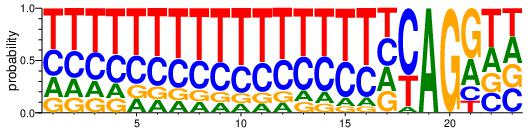

In [41]:
sl.seqlogo( ppm_sl, ic_scale = False, format = 'jpeg', size = 'medium')

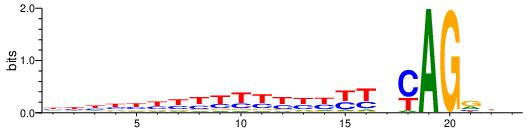

In [42]:
sl.seqlogo( ppm_sl, ic_scale = True, format = 'jpeg', size = 'medium')